In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from scipy.optimize import minimize

# Méthodologie ML

## Génération des données

In [4]:
def inconnue(x):
    return np.cos(10. * x) * np.exp(- x / 2)

In [5]:
xs = np.linspace(0, 2, 200)
ys = inconnue(xs)

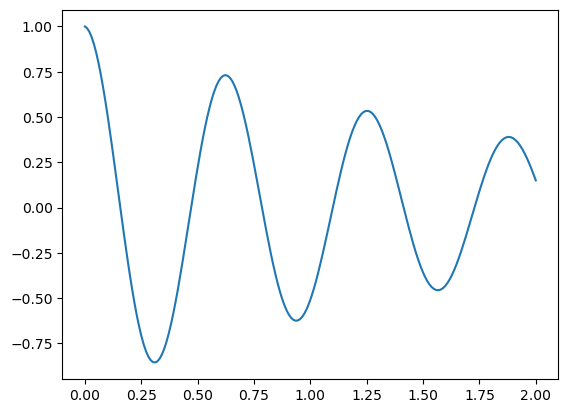

In [6]:
plt.plot(xs, ys)

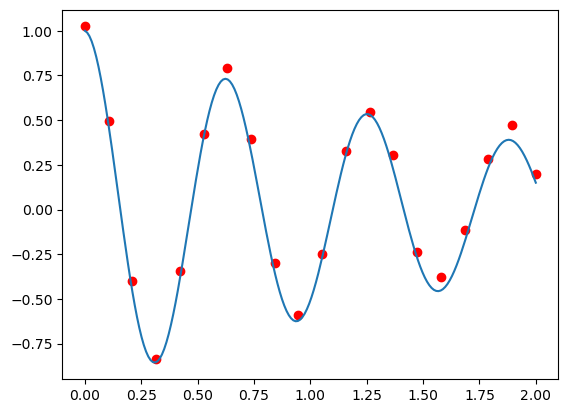

In [10]:
nb_points = 20
xl, xr = 0, 2

eps = 0.1

XS = np.linspace(xl, xr, nb_points)
YS = inconnue(XS) + eps * np.random.rand(nb_points)

plt.plot(xs, ys)
plt.scatter(XS, YS, color='red')

## ML

La problèmatique est la suivante : connaissant les points rouges $(x_1, y_1)\ldots, (x_N, y_N)$, on veut reconstruire la courbe bleue.

### Régression linéaire

On cherche la courbe bleue parmis les fonctions 

$$
x \mapsto a x + b
$$

celle qui "colle" le mieux au nuage de points rouges.

Pour ça on a besoin d'une fonction d'erreur.

$$
J_2(a,b) = \sum_{i=1}^N (y_i - (a x_i + b))^2.
$$

On cherche $(a,b)$ minimisant $J_2$.

A ce stade, l'erreur quadratique paraît arbitraire, on pourrait imaginer minimiser

$$
J_1(a,b) = \sum_{i=1}^N | y_i - (a x_i + b)|.
$$

**REMARQUE** l'avantage de l'erreur quadratique est qu'en annulant le gradient on se retrouve à résoudre un système linéaire en $(a,b)$. On peut donc trouver des formules explicites.

**EXERCICE** :

1. Coder la fonction $J_2$ en python
2. Utiliser `minimize` pour trouver $(a,b)$.

In [11]:
def J2(ps):
    a, b = ps
    return np.sum((YS - a * XS - b) ** 2)

In [13]:
resultat = minimize(J2, [0, 0])
resultat

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.616642878470923
        x: [-2.273e-02  1.134e-01]
      nit: 2
      jac: [ 1.788e-07  0.000e+00]
 hess_inv: [[ 4.322e-01 -4.961e-01]
            [-4.961e-01  5.961e-01]]
     nfev: 15
     njev: 5

In [15]:
a ,b = resultat.x

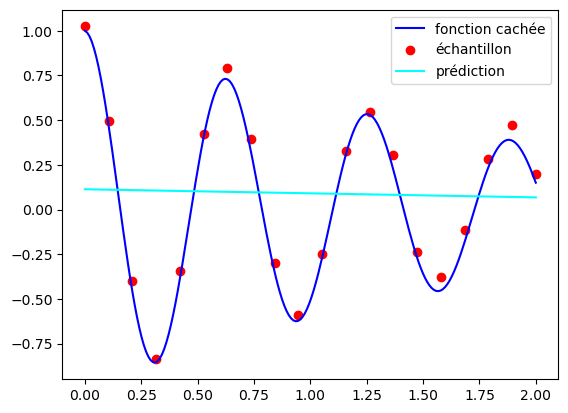

In [16]:
plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, a * xs + b, color="cyan", label="prédiction")
plt.legend()

**CONCLUSION** On voit que le modèle n'est pas satisfaisant.
Mais surtout on voit même à partir des points rouge que le modèle n'est pas satisfaisant il reste loin de l'échantillon.

Fondamentalement, le modèle n'est pas assez complexe pour reproduire l'échantillon, on voit que le minimum de $J_2$ est resté à 4.6.

## Nouveau modèle

On va chercher le prédicteur parmi les polynômes de degrés inférieur à un certain entier $d$.

$$
x\mapsto \sum_{k=0}^d a_k x^k
$$

Les $(a_0,...,a_d)$ sont les paramètres qu'on obtiendra automatiquement par minimisation de l'erreur.

Par contre, $d$ est un hyperparamètre, qui est choisi par le modélisateur.

**EXERCICE**
Effectuer l'entrainement pour $d=5$.

In [19]:
d = 5

def erreur(ps):
    residus = np.zeros_like(XS)
    puissances = np.ones_like(XS)
    for p in ps:
        residus = residus + p * puissances
        puissances = puissances * XS
    return np.sum((residus - YS) ** 2)
        

In [20]:
resultat = minimize(erreur, np.zeros(d+1))
resultat

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.061133730243934
        x: [ 1.068e+00 -1.155e+01  3.302e+01 -3.767e+01  1.862e+01
            -3.321e+00]
      nit: 28
      jac: [-2.086e-07 -8.047e-07 -5.960e-07  1.788e-07 -5.960e-07
            -5.960e-08]
 hess_inv: [[ 4.255e-01 -3.550e+00 ...  5.007e+00 -9.042e-01]
            [-3.550e+00  5.227e+01 ... -1.062e+02  1.998e+01]
            ...
            [ 5.007e+00 -1.062e+02 ...  2.983e+02 -5.894e+01]
            [-9.042e-01  1.998e+01 ... -5.894e+01  1.175e+01]]
     nfev: 224
     njev: 32

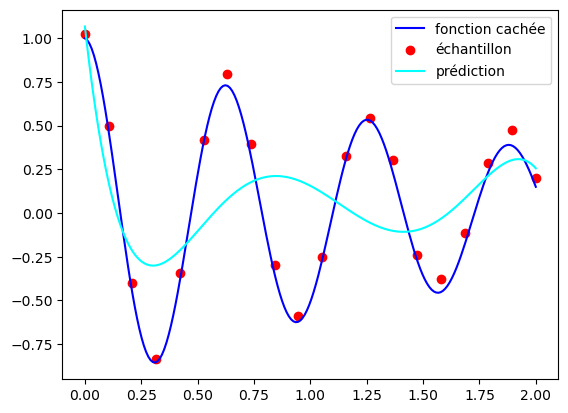

In [21]:
ps = resultat.x
residus = np.zeros_like(xs)
puissances = np.ones_like(xs)
for p in ps:
    residus = residus + p * puissances
    puissances = puissances * xs
    
plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, residus, color="cyan", label="prédiction")
plt.legend()

**CONCLUSION** il y a du mieux mais on reste loin d'avoir une erreur négligeable.

## Refactor du code

In [24]:
class Polynome:
    def __init__(self, coefficients: list[float]):
        self.coefficients = coefficients
            
    def degres(self) -> int:
        return len(self.coefficients) - 1
    
    def __call__(self, xs):
        residus = np.zeros_like(xs)
        puissances = np.ones_like(xs)
        for p in self.coefficients:
            residus = residus + p * puissances
            puissances = puissances * xs
        return residus

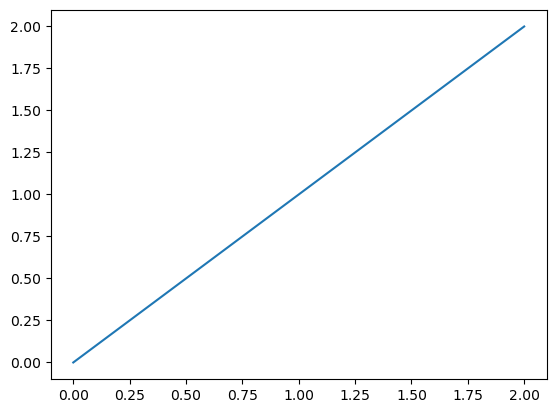

In [25]:
identite = Polynome([0, 1])
plt.plot(xs, identite(xs))

In [26]:
def erreur(ps):
    modele = Polynome(ps)
    return np.sum((modele(XS) - YS)**2)

In [27]:
d = 8
resultat = minimize(erreur, x0=np.zeros(d+1))
resultat

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.1210357913323303
        x: [ 1.041e+00  6.751e+00 -1.969e+02  9.570e+02 -2.029e+03
             2.252e+03 -1.365e+03  4.275e+02 -5.420e+01]
      nit: 86
      jac: [-1.873e-04 -1.008e-04 -5.560e-05  3.004e-05 -3.488e-05
            -1.317e-04  7.954e-05  8.816e-05  6.741e-05]
 hess_inv: [[ 2.606e-01 -9.301e-01 ...  4.784e-02 -4.914e-03]
            [-9.301e-01  4.338e+00 ...  1.500e-01 -8.420e-02]
            ...
            [ 4.784e-02  1.500e-01 ...  2.900e-01 -8.899e-02]
            [-4.914e-03 -8.420e-02 ... -8.899e-02  2.782e-02]]
     nfev: 1752
     njev: 174

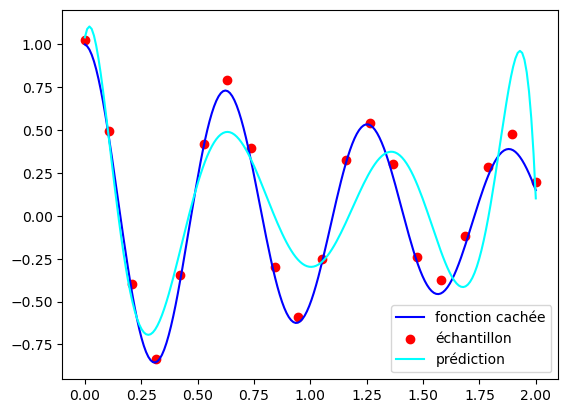

In [28]:
predicteur = Polynome(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.8540390187352507
        x: [ 1.137e+00 -9.845e+00 -2.690e+00  1.090e+02 -1.860e+02
             4.075e+01  1.177e+02 -6.834e+01 -2.187e+01  2.512e+01
            -5.097e+00]
      nit: 52
      jac: [-1.059e-03 -2.937e-04 -3.105e-04  4.086e-04  2.036e-04
            -2.136e-04  9.810e-04  2.159e-03  1.331e-03  2.043e-03
            -1.661e-03]
 hess_inv: [[ 5.019e-01 -1.157e+01 ... -2.425e+00  1.117e+00]
            [-1.157e+01  6.021e+02 ...  1.864e+02 -7.541e+01]
            ...
            [-2.425e+00  1.864e+02 ...  1.528e+02 -4.385e+01]
            [ 1.117e+00 -7.541e+01 ... -4.385e+01  1.391e+01]]
     nfev: 1031
     njev: 85


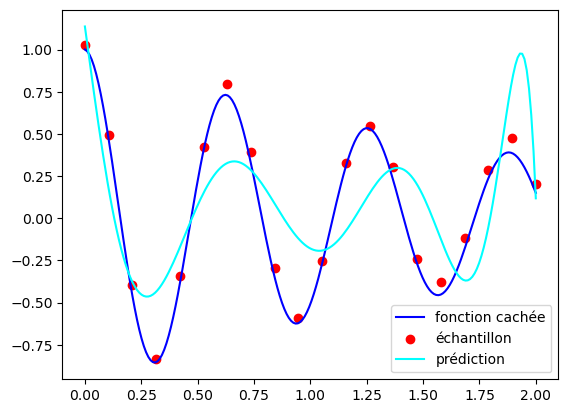

In [29]:
d = 10
resultat = minimize(erreur, x0=np.zeros(d+1))
print(resultat)
predicteur = Polynome(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()


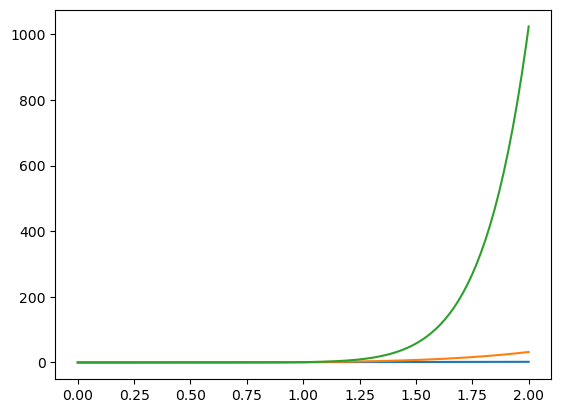

In [31]:
plt.plot(xs, xs)
plt.plot(xs, xs ** (d // 2))
plt.plot(xs, xs ** d)

**CONCLUSION** le solveur n'arrive pas à converger. Le problème n'est pas tant d'avoir choisi un modèle polynomial, mais de le paramétrer avec la base des puissances de $x$.

In [32]:
def erreur(ps):
    modele = np.polynomial.Chebyshev(ps)
    return np.sum((modele(XS) - YS)**2)


In [33]:
d = 10
resultat = minimize(erreur, x0=np.zeros(d+1))
print(resultat)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.31151746339898
        x: [ 2.612e-01 -1.572e-01 -4.685e-01  1.018e-01  3.176e-01
            -4.868e-01 -4.050e-01  1.090e+00 -6.729e-01  1.679e-01
            -1.502e-02]
      nit: 9
      jac: [ 2.871e-01  9.150e-01  1.715e+00  2.325e+00  5.603e+00
             1.396e+01  2.597e+01  3.653e+01  2.238e+01 -9.520e+01
             2.387e+01]
 hess_inv: [[ 3.014e-01 -3.816e-01 ...  3.596e-04 -4.511e-05]
            [-3.816e-01  6.392e-01 ...  3.616e-04  2.818e-05]
            ...
            [ 3.596e-04  3.616e-04 ...  7.198e-03 -6.187e-04]
            [-4.511e-05  2.818e-05 ... -6.187e-04  5.370e-05]]
     nfev: 804
     njev: 66


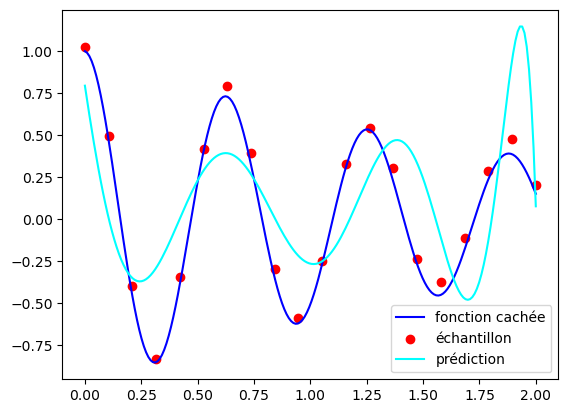

In [34]:
predicteur = np.polynomial.Chebyshev(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.2218049511261135
        x: [ 8.142e-01 -8.859e-01 -6.952e-01  1.032e+00  3.800e-01
            -1.769e+00 -3.839e-01  2.596e+00 -1.791e+00  4.760e-01
            -4.474e-02]
      nit: 11
      jac: [ 8.949e-03  2.216e-01  1.615e-01 -1.422e-01 -1.127e-01
             2.463e-01  1.956e-01 -2.417e-01  3.370e-01 -2.090e-01
             3.108e-02]
 hess_inv: [[ 2.747e-01 -3.795e-01 ...  5.097e-02 -4.533e-03]
            [-3.795e-01  7.099e-01 ... -5.402e-02  4.898e-03]
            ...
            [ 5.097e-02 -5.402e-02 ...  4.533e-02 -4.153e-03]
            [-4.533e-03  4.898e-03 ... -4.153e-03  3.832e-04]]
     nfev: 612
     njev: 50


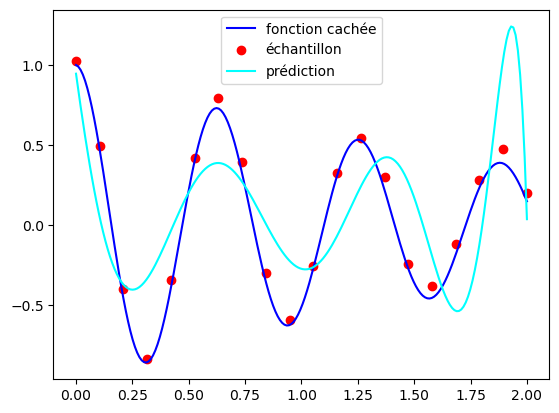

In [37]:

def erreur(ps):
    modele = np.polynomial.Legendre(ps)
    return np.sum((modele(XS) - YS)**2)

d = 10
resultat = minimize(erreur, x0=np.zeros(d+1))
print(resultat)
predicteur = np.polynomial.Legendre(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.894022397783293
        x: [ 5.465e+01 -2.395e+02  2.825e+02  9.820e+01 -2.309e+02
            -1.955e+02  1.229e+02  2.940e+02  2.189e+01 -3.982e+02
             1.911e+02]
      nit: 46
      jac: [-2.553e-04 -1.284e-04 -4.649e-05 -1.174e-05  2.980e-08
            -2.265e-06  1.022e-05  2.274e-05  4.205e-05  8.529e-05
             1.189e-04]
 hess_inv: [[ 1.646e+04 -7.050e+04 ... -1.045e+05  4.706e+04]
            [-7.050e+04  3.021e+05 ...  4.481e+05 -2.020e+05]
            ...
            [-1.045e+05  4.481e+05 ...  6.681e+05 -3.019e+05]
            [ 4.706e+04 -2.020e+05 ... -3.019e+05  1.365e+05]]
     nfev: 948
     njev: 78


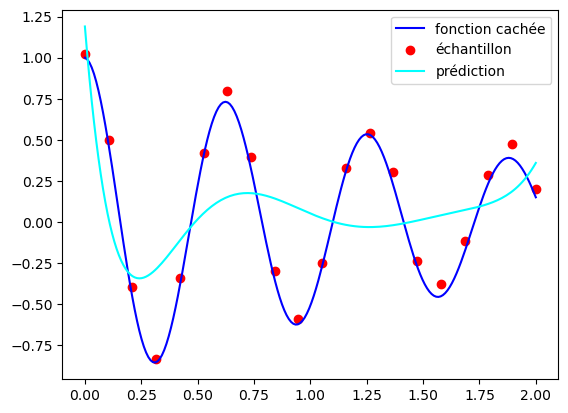

In [38]:

def erreur(ps):
    modele = np.polynomial.Laguerre(ps)
    return np.sum((modele(XS) - YS)**2)

d = 10
resultat = minimize(erreur, x0=np.zeros(d+1))
print(resultat)
predicteur = np.polynomial.Laguerre(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.1239791414243725
        x: [-2.103e-01 -1.143e+00 -2.770e+00 -3.839e+00 -2.243e+00
             3.397e-01 -1.122e+00  2.187e-01 -9.828e-02  8.582e-03
            -1.773e-03]
      nit: 13
      jac: [ 4.397e-01  5.917e-01  1.254e+00  3.422e+00  3.675e+00
            -1.780e+01 -6.914e+01  2.659e+01  5.150e+02 -1.132e+02
             2.386e+01]
 hess_inv: [[ 1.013e+00  8.991e-02 ... -1.191e-03  2.860e-04]
            [ 8.991e-02  1.248e+00 ... -2.007e-03  5.132e-04]
            ...
            [-1.191e-03 -2.007e-03 ...  1.152e-05 -2.401e-06]
            [ 2.860e-04  5.132e-04 ... -2.401e-06  5.414e-07]]
     nfev: 731
     njev: 60


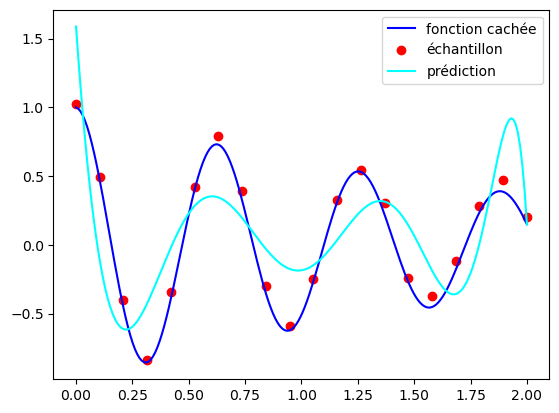

In [40]:

def erreur(ps):
    modele = np.polynomial.Hermite(ps)
    return np.sum((modele(XS) - YS)**2)

d = 10
resultat = minimize(erreur, x0=np.zeros(d+1))
print(resultat)
predicteur = np.polynomial.Hermite(resultat.x)

plt.plot(xs, ys, color="blue", label="fonction cachée")
plt.scatter(XS, YS, color='red', label="échantillon")
plt.plot(xs, predicteur(xs), color="cyan", label="prédiction")
plt.legend()

**EXERCICE** : On pourrait implémenter la base de Bernstein sur $[a, b]$ qui aux cofficients $(c_0, ..., c_d)$ associe

$$
\sum_{k=0}^d c_k \binom{d}{k} \left(\frac{x-a}{b-a}\right)^k \left(\frac{b-x}{b-a}\right)^{d-k}
$$

In [41]:
from scipy.special import binom

In [42]:
class Bernstein:
    def __init__(self, a, b, coefficients):
        self.a = a
        self.b = b
        self.coefficients = coefficients
        
    def __call__(self, xs):
        y = (xs - a) / (b - a)
        somme = 0
        for (k, c) in enumerate(coefficients):
            somme = somme + c * y ** k * binom(len(self.coefficients), k) * (1 - y) ** (d - k)
        return somme 

**EXERCICE** 
1. Visualiser la base de Bernstein pour des petites valeurs.
2. Faire l'entrainement dans cette base.